In [0]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
from IPython.display import Image
from IPython.core.display import Image, display
import numpy as np

batch_size = 100

In [0]:
from google.colab import drive

drive.mount('/gdrive')
gdrive_root = '/gdrive/My Drive/results2/'

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [0]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [0]:
import zipfile
from PIL import Image
import torchvision.transforms.functional as TF

np.random.seed(0)

archive = zipfile.ZipFile('/gdrive/My Drive/2019Fall/images_labeled.zip', 'r')

pick_number = 5000
shoes_images = torch.tensor(np.empty([pick_number, 3, 136, 136])).type(torch.DoubleTensor)
print(shoes_images.size())


picked_list = np.random.choice(50000, pick_number, replace=False)
print(picked_list)

torch.Size([5000, 3, 136, 136])
[11841 19602 45519 ... 12143 34963 23333]


In [0]:
#print(archive.namelist())
for i in range(pick_number):
  
  imgfile = archive.open('images/' + str(picked_list[i]+1) + '.jpg')
  imgfile = TF.to_tensor(Image.open(imgfile)).type(torch.DoubleTensor)
  
  if(imgfile.size(1)!=136 or imgfile.size(2)!=136):
    print("nono..")
    continue
  shoes_images[i] = imgfile

print(shoes_images.size())

torch.Size([5000, 3, 136, 136])


In [0]:
shoes_dataloader = torch.utils.data.DataLoader(dataset=shoes_images,
                                              batch_size=batch_size,
                                              shuffle=False)

torch.Size([16, 3, 136, 136])
torch.DoubleTensor


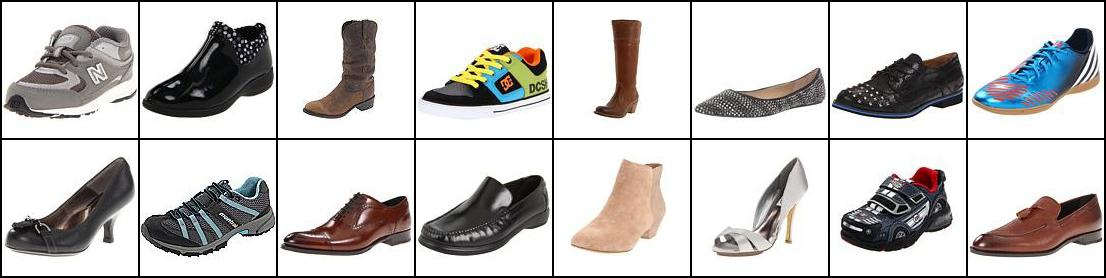

In [0]:
from IPython.display import Image
from IPython.core.display import Image, display

fixed_x = next(iter(shoes_dataloader))
recon_test_data = fixed_x[0:16]

# channels is 3 (R, G, B)
image_channels = fixed_x.size(1)
print(recon_test_data.size())
print(recon_test_data.type())
save_image(recon_test_data, 'temp.jpg')
Image('temp.jpg')

In [0]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

In [0]:
class UnFlatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), 40, 6, 6)

In [0]:
class VAE(nn.Module):
    def __init__(self, image_channels, h_dim=36*40, z_dim=100):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(image_channels, 6, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(6, 12, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Conv2d(12, 24, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Conv2d(24, 30, kernel_size=4, stride=1),
            nn.ReLU(),
            nn.Conv2d(30, 40, kernel_size=3, stride=2),
            nn.ReLU(),
            Flatten()
            # 1440
        )
        
        self.fc1 = nn.Linear(h_dim, z_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(z_dim, h_dim)
        
        self.decoder = nn.Sequential(
             UnFlatten(),
             nn.ConvTranspose2d(40, 30, kernel_size=3, stride=2),
             nn.ReLU(),
             nn.ConvTranspose2d(30, 24, kernel_size=4, stride=1),
             nn.ReLU(), 
             nn.ConvTranspose2d(24, 12, kernel_size=3, stride=2),    
             nn.ReLU(), 
             nn.ConvTranspose2d(12, 6, kernel_size=3, stride=2),  
             nn.ReLU(), 
             nn.ConvTranspose2d(6, image_channels, kernel_size=4, stride=2),  
             nn.Sigmoid(),
        )
        
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        # return torch.normal(mu, std)
        esp = torch.randn(*mu.size()).to(device)
        z = mu + std * esp
        return z
    
    def bottleneck(self, h):
        mu, logvar = self.fc1(h), self.fc2(h)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar

    def encode(self, x):
        h = self.encoder(x)
        z, mu, logvar = self.bottleneck(h)
        return z, mu, logvar

    def decode(self, z):
        z = self.fc3(z)
        z = self.decoder(z)
        return z

    def forward(self, x):
        z, mu, logvar = self.encode(x)
        z = self.decode(z)
        return z, mu, logvar

In [0]:
print(len(fixed_x))
model = VAE(image_channels=image_channels).type('torch.DoubleTensor').to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

100


In [0]:
ckpt_dir = os.path.join(gdrive_root, 'checkpoints')
if not os.path.exists(ckpt_dir):
  os.makedirs(ckpt_dir)
  
best_loss = 999999999
ckpt_path = os.path.join(ckpt_dir, 'shoes_model.pt')
if os.path.exists(ckpt_path):
  ckpt = torch.load(ckpt_path)
  try:
    model.load_state_dict(ckpt['VAE_model'])
    optimizer.load_state_dict(ckpt['optimizer'])
    best_loss = ckpt['best_loss']
  except RuntimeError as e:
      print('wrong checkpoint')
  else:    
    print('checkpoint is loaded !')
    print('current best loss : %.2f' % best_loss)

In [0]:
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 55488), reduction='sum')

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD, BCE, KLD

In [0]:
def train(epoch):
    model.train()
    train_loss = 0
    train_loss1 = 0
    train_loss2 = 0
    for batch_idx, data in enumerate(shoes_dataloader):
        data = data.to(device).double()
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data.double())
        loss, loss1, loss2 = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        train_loss1 += loss1.item()
        train_loss2 += loss2.item()
        optimizer.step()
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\t\t Loss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(shoes_dataloader.dataset),
                100. * batch_idx / len(shoes_dataloader),
                loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(shoes_dataloader.dataset)))
    return train_loss/len(shoes_dataloader.dataset), train_loss1/len(shoes_dataloader.dataset), train_loss2/len(shoes_dataloader.dataset)

In [0]:
from IPython.core.display import Image, display

loss1_list = []
loss2_list = []

for epoch in range(1, 1000):
    train_loss, loss1, loss2 = train(epoch)
    loss1_list.append(loss1)
    loss2_list.append(loss2)
    #test_loss = test(epoch)
    print(int(train_loss), int(best_loss))
    # save checkpoint whenever there is improvement in performance
    if train_loss < best_loss:
      best_loss = train_loss
      # Note: optimizer also has states ! don't forget to save them as well.
      ckpt = {'VAE_model':model.state_dict(),
              'optimizer':optimizer.state_dict(),
              'best_loss':best_loss}
      torch.save(ckpt, ckpt_path)
      print('checkpoint is saved !')
    if epoch % 5 == 0 :
      with torch.no_grad():
          print("**************")
          print("saving image..")
          print("**************")
          a, b, c = model.forward(recon_test_data.view(16, 3, 136, 136).to(device))
          save_image(a.view(16, 3, 136, 136), gdrive_root + 'recon_sample_' + str(epoch) + '.png')

          sample = torch.randn(16, 100).type('torch.DoubleTensor').to(device)
          sample = model.decode(sample).cpu()
          save_image(sample.view(16, 3, 136, 136),
                      gdrive_root + 'sample_' + str(epoch) + '.png')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Using a target size (torch.Size([100, 55488])) that is different to the input size (torch.Size([100, 3, 136, 136])) is deprecated. Please ensure they have the same size.
  


Train Epoch: 1 [0/5000 (0%)]		 Loss: 38187.944092
Train Epoch: 1 [1000/5000 (20%)]		 Loss: 37739.812557
Train Epoch: 1 [2000/5000 (40%)]		 Loss: 36623.337378
Train Epoch: 1 [3000/5000 (60%)]		 Loss: 30066.934754
Train Epoch: 1 [4000/5000 (80%)]		 Loss: 22958.417208
====> Epoch: 1 Average loss: 31591.5585
31591 999999999
checkpoint is saved !
Train Epoch: 2 [0/5000 (0%)]		 Loss: 20074.262847
Train Epoch: 2 [1000/5000 (20%)]		 Loss: 18113.689608
Train Epoch: 2 [2000/5000 (40%)]		 Loss: 17221.775514
Train Epoch: 2 [3000/5000 (60%)]		 Loss: 17112.603710
Train Epoch: 2 [4000/5000 (80%)]		 Loss: 15633.540117
====> Epoch: 2 Average loss: 17283.1714
17283 31591
checkpoint is saved !
Train Epoch: 3 [0/5000 (0%)]		 Loss: 15033.239948
Train Epoch: 3 [1000/5000 (20%)]		 Loss: 14275.474417
Train Epoch: 3 [2000/5000 (40%)]		 Loss: 14225.403969
Train Epoch: 3 [3000/5000 (60%)]		 Loss: 14624.812613
Train Epoch: 3 [4000/5000 (80%)]		 Loss: 13629.460106
====> Epoch: 3 Average loss: 14484.6352
14484 1728

In [0]:
print(loss1_list)
print(loss2_list)

[31442.97280409722, 17077.922669911262, 14345.220786518064, 13458.034604616023, 13032.766409523014, 12807.764761431883, 12623.325057351743, 12474.980189343014, 12364.820671206306, 12259.798199477807, 12127.460298220063, 12027.279811632057, 11920.091809830503, 11820.021226190564, 11729.332415862156, 11649.650875148021, 11563.193881273226, 11492.280880751903, 11414.097721020917, 11351.06990481403, 11292.56050912064, 11225.11644920113, 11435.438464569028, 11176.252687179767, 11093.158682453619, 11036.350149950238, 10993.72588670998, 10954.103238026159, 10902.029298287514, 10863.951955058506, 10828.566264096955, 10792.01003968968, 10764.38479900413, 10728.691902308403, 10712.343352892995, 10662.458619982921, 10633.052295950778, 10604.959658090927, 10590.830072646168, 10574.790684515006, 10539.150443295548, 10504.584876768951, 10482.790614498383, 10462.25315499732, 10445.986483279003, 10427.591033759898, 10403.128850710484, 10387.896611107682, 10371.047054969256, 10367.334087714875, 10370.2

In [0]:
import csv

f = open(gdrive_root + '/file_name.csv', 'w', encoding='utf-8')
wr = csv.writer(f)

for i, data in enumerate(shoes_dataloader):
  data = data.to(device)
  z, _, _ = model.type('torch.cuda.DoubleTensor').encode(data)
  for line in z.tolist():
    wr.writerow(line)

f.close()

  #if (i+1) % 5 == 0 :
  #  break
# index, channel, 가로, 세로

input your index :0
original image


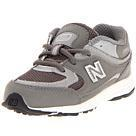

recommend image


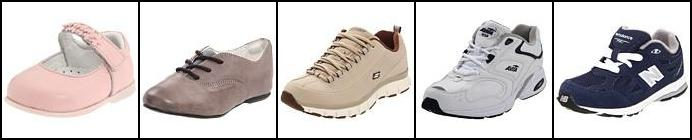

input your index :7
original image


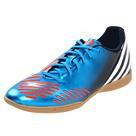

recommend image


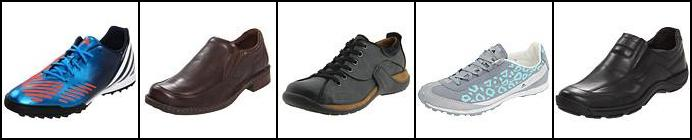

input your index :10
original image


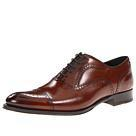

recommend image


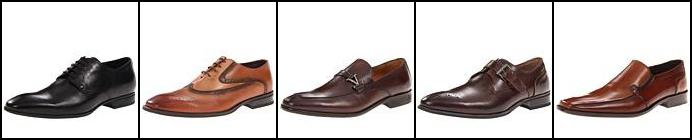

input your index :99
original image


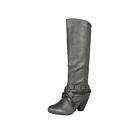

recommend image


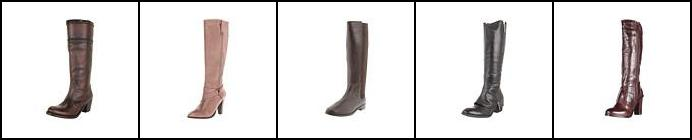

input your index :100
original image


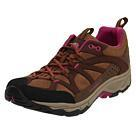

recommend image


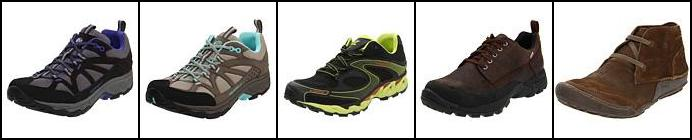

input your index :200
original image


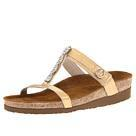

recommend image


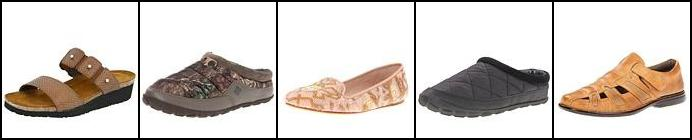

input your index :4999
original image


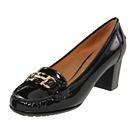

recommend image


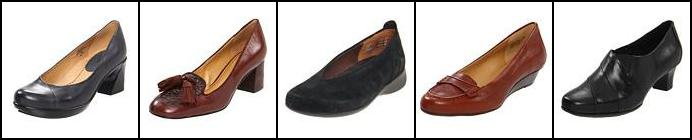

KeyboardInterrupt: ignored

In [0]:
while True :
  search_index = int(input("input your index :"))
  base = []

  recommend_value = [10000, 10001, 10002, 10003, 10004]
  recommend_index = [0, 0, 0, 0, 0]

  f = open(gdrive_root + '/file_name.csv', 'r', encoding='utf-8')
  rdr = csv.reader(f)

  i=0
  for line in rdr:
    if i == search_index :
      base = line
      break
    i += 1

  base = np.array([float(i) for i in base])

  # 처음부터 읽기 위해서 다시 open 해야 함
  f.close()
  f = open(gdrive_root + '/file_name.csv', 'r', encoding='utf-8')

  # 가장 가까운 5개 찾기
  k = 0
  rdr = csv.reader(f)
  for line in rdr:

    # 자기 자신은 제외하고 검색
    if k == search_index :
      k = k + 1
      continue

    now = np.array([float(i) for i in line])
    now_value = np.linalg.norm(base-now)
    
    flag = 0
    before = len(recommend_value) - 1
    
    for i in range(len(recommend_value)):
      if recommend_value[4-i] > now_value :
        if flag == 0:
          recommend_value[4-i] = now_value
          recommend_index[4-i] = k
          flag = 1
        else :
          recommend_value[4-i] ,recommend_value[before] = recommend_value[before], recommend_value[4-i]
          recommend_index[4-i] ,recommend_index[before] = recommend_index[before], recommend_index[4-i]
        before = 4 - i
    k = k + 1

  f.close()

  #print(recommend_value)
  #print(recommend_index)

  from PIL import Image
  from IPython.core.display import Image as Image_show
  from IPython.core.display import display

  imgfile = archive.open('images/' + str(picked_list[search_index]+1) + '.jpg')
  imgfile = TF.to_tensor(Image.open(imgfile)).type(torch.DoubleTensor).view(1, 3, 136, 136)
  print("original image")
  save_image(imgfile, 'temp.jpg')
  display(Image_show('temp.jpg'))

  img_list = torch.tensor(np.empty([5, 3, 136, 136])).type(torch.DoubleTensor)

  for i in range(len(recommend_value)):
    
    imgfile = archive.open('images/' + str(picked_list[recommend_index[i]]+1) + '.jpg')
    img_list[i] = TF.to_tensor(Image.open(imgfile)).type(torch.DoubleTensor).view(3, 136, 136)

  save_image(img_list, 'temp.jpg')
  print("recommend image")
  display(Image_show('temp.jpg'))